## IMPORTING NECESSARY LIBRARIES

In [1]:
!pip install pyDOE

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18170 sha256=52f299199f2545d56de47313cab3a3d60cc2dd9d7cd1e2ae9b1526a59d2e99b5
  Stored in directory: /root/.cache/pip/wheels/84/20/8c/8bd43ba42b0b6d39ace1219d6da1576e0dac81b12265c4762e
Successfully built pyDOE


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import grad
from scipy.interpolate import griddata
from sklearn.metrics import mean_squared_error
from pyDOE import lhs  # for Latin Hypercube Sampling


## 1. In this assignment, you will use Physics-Informed Neural Networks(PINNs) to estimate cardiac activation times on a 2D domain using sparse data. You will compare the PINN approach with a purely data-driven neural network and linear interpolation.

### PART A

## a) Define the activation time function T(x,y)

In [6]:
def T_true(x, y):
    dist1 = np.sqrt(x**2 + y**2)
    dist2 = np.sqrt((x - 1)**2 + (y - 1)**2)
    return np.minimum(dist1, np.sqrt(0.7) * dist2)


## (b) Define the conduction velocity function V(x,y)

In [8]:
def V(x, y):
    dist1 = x**2 + y**2
    dist2 = (x - 1)**2 + (y - 1)**2
    return np.where(dist1 < 0.7 * dist2, 1.0, 1.0 / 0.7)


## c) Generate sparse training samples using Latin Hypercube Sampling

In [9]:
n_samples = 30
lhs_samples = lhs(2, samples=n_samples)
x_train = lhs_samples[:, 0] * 2 - 1  # Scale to [-1, 1]
y_train = lhs_samples[:, 1] * 2 - 1

t_train = T_true(x_train, y_train)


### PART B

## a) Defining a neutral network

In [11]:
class FeedForwardNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train = torch.tensor(np.vstack((x_train, y_train)).T, dtype=torch.float32).to(device)
T_train = torch.tensor(t_train[:, None], dtype=torch.float32).to(device)


## b)  Training on data only and PINNs

In [13]:
# === Part A: Imports and Data Generation ===

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import grad
from pyDOE import lhs
from sklearn.metrics import mean_squared_error

# Activation time function
def T_true(x, y):
    dist1 = np.sqrt(x**2 + y**2)
    dist2 = np.sqrt((x - 1)**2 + (y - 1)**2)
    return np.minimum(dist1, np.sqrt(0.7) * dist2)

# Conduction velocity function
def V(x, y):
    dist1 = x**2 + y**2
    dist2 = (x - 1)**2 + (y - 1)**2
    return np.where(dist1 < 0.7 * dist2, 1.0, 1.0 / 0.7)

# Latin Hypercube Sampling
n_samples = 30
lhs_samples = lhs(2, samples=n_samples)
x_train = lhs_samples[:, 0] * 2 - 1
y_train = lhs_samples[:, 1] * 2 - 1
t_train = T_true(x_train, y_train)

# Prepare PyTorch data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train = torch.tensor(np.stack((x_train, y_train), axis=1), dtype=torch.float32).to(device)
T_train = torch.tensor(t_train[:, None], dtype=torch.float32).to(device)

# === Part B: Define Feedforward Neural Network ===

class FeedForwardNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

# === Model 1: Data-Only Neural Network Training ===

model_data = FeedForwardNN().to(device)
optimizer_data = torch.optim.Adam(model_data.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(5000):
    optimizer_data.zero_grad()
    pred = model_data(X_train)
    loss = loss_fn(pred, T_train)
    loss.backward()
    optimizer_data.step()
    if epoch % 500 == 0:
        print(f"[Data NN] Epoch {epoch}, Loss: {loss.item():.5f}")

# === Model 2: Physics-Informed Neural Network Training ===

model_pinn = FeedForwardNN().to(device)
optimizer_pinn = torch.optim.Adam(model_pinn.parameters(), lr=1e-3)

def eikonal_residual(model, x):
    x.requires_grad_(True)
    t_pred = model(x)
    grads = grad(t_pred, x, grad_outputs=torch.ones_like(t_pred), create_graph=True)[0]
    grad_norm = torch.norm(grads, dim=1, keepdim=True)

    v_vals = V(x[:, 0].detach().cpu().numpy(), x[:, 1].detach().cpu().numpy())
    v_vals = torch.tensor(v_vals[:, None], dtype=torch.float32).to(x.device)

    residual = v_vals * grad_norm - 1.0
    return (residual**2).mean()

for epoch in range(5000):
    optimizer_pinn.zero_grad()
    loss = eikonal_residual(model_pinn, X_train)
    loss.backward()
    optimizer_pinn.step()
    if epoch % 500 == 0:
        print(f"[PINN] Epoch {epoch}, Loss: {loss.item():.5f}")



[Data NN] Epoch 0, Loss: 0.49141
[Data NN] Epoch 500, Loss: 0.00090
[Data NN] Epoch 1000, Loss: 0.00020
[Data NN] Epoch 1500, Loss: 0.00006
[Data NN] Epoch 2000, Loss: 0.00004
[Data NN] Epoch 2500, Loss: 0.00003
[Data NN] Epoch 3000, Loss: 0.00002
[Data NN] Epoch 3500, Loss: 0.00001
[Data NN] Epoch 4000, Loss: 0.00001
[Data NN] Epoch 4500, Loss: 0.00001
[PINN] Epoch 0, Loss: 0.55980
[PINN] Epoch 500, Loss: 0.00201
[PINN] Epoch 1000, Loss: 0.00080
[PINN] Epoch 1500, Loss: 0.00004
[PINN] Epoch 2000, Loss: 0.00002
[PINN] Epoch 2500, Loss: 0.00001
[PINN] Epoch 3000, Loss: 0.00001
[PINN] Epoch 3500, Loss: 0.00000
[PINN] Epoch 4000, Loss: 0.00000
[PINN] Epoch 4500, Loss: 0.00000


## Evaluation and Visualization


RMSE (Data-Only NN): 0.59705
RMSE (PINN): 1.06373


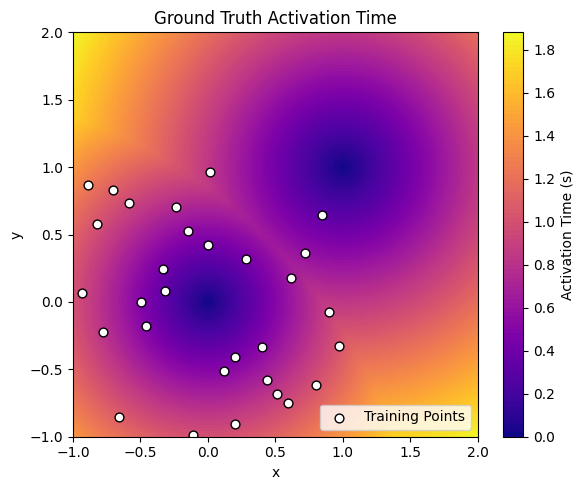

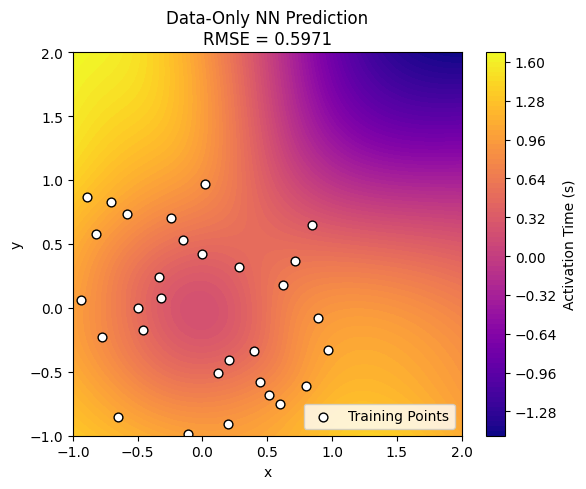

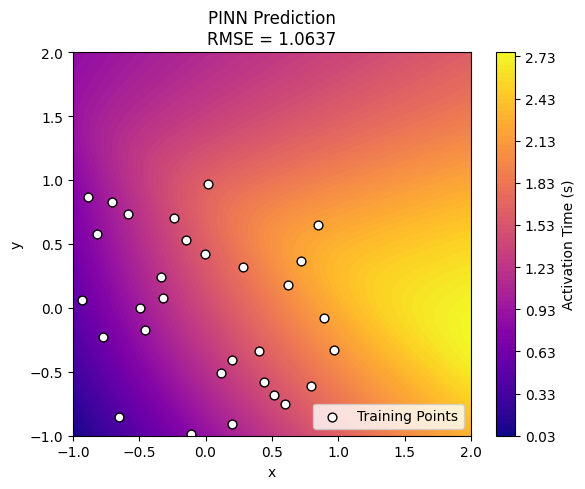

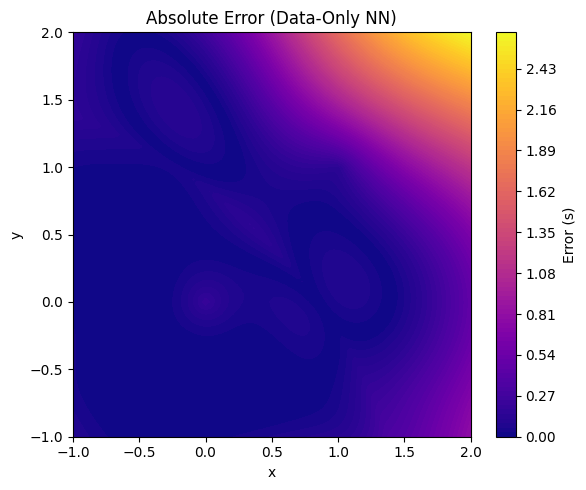

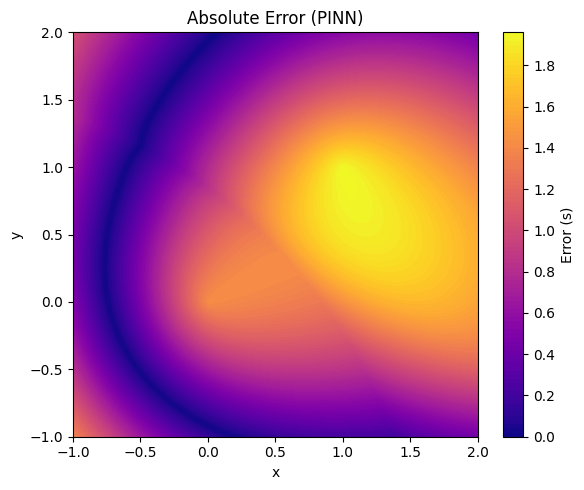

In [14]:
# === Part C: Evaluation and Visualization ===

# Create mesh grid for predictions
grid_x, grid_y = np.meshgrid(np.linspace(-1, 2, 100), np.linspace(-1, 2, 100))
grid_coords = np.stack([grid_x.ravel(), grid_y.ravel()], axis=1)

# Ground truth values on the grid
T_grid_true = T_true(grid_coords[:, 0], grid_coords[:, 1])

# Predict with both models
with torch.no_grad():
    X_grid = torch.tensor(grid_coords, dtype=torch.float32).to(device)
    T_pred_data = model_data(X_grid).cpu().numpy().ravel()
    T_pred_pinn = model_pinn(X_grid).cpu().numpy().ravel()

# Compute RMSE
rmse_data = np.sqrt(mean_squared_error(T_grid_true, T_pred_data))
rmse_pinn = np.sqrt(mean_squared_error(T_grid_true, T_pred_pinn))

print(f"\nRMSE (Data-Only NN): {rmse_data:.5f}")
print(f"RMSE (PINN): {rmse_pinn:.5f}")

# Function to plot heatmaps with colorbar and training points
def plot_heatmap(values, title, colorbar_label, scatter_points=True):
    plt.figure(figsize=(6, 5))
    contour = plt.contourf(grid_x, grid_y, values.reshape(grid_x.shape), levels=100, cmap='plasma')
    cb = plt.colorbar(contour)
    cb.set_label(colorbar_label)

    # Overlay training points (optional)
    if scatter_points:
        plt.scatter(x_train, y_train, color='white', edgecolor='black', s=40, label='Training Points')
        plt.legend(loc='lower right')

    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.tight_layout()

# === Plot all ===

# Ground truth activation map
plot_heatmap(T_grid_true, "Ground Truth Activation Time", "Activation Time (s)")

# Data-only NN prediction
plot_heatmap(T_pred_data, f"Data-Only NN Prediction\nRMSE = {rmse_data:.4f}", "Activation Time (s)")

# PINN prediction
plot_heatmap(T_pred_pinn, f"PINN Prediction\nRMSE = {rmse_pinn:.4f}", "Activation Time (s)")

# Error maps
plot_heatmap(np.abs(T_grid_true - T_pred_data), "Absolute Error (Data-Only NN)", "Error (s)", scatter_points=False)
plot_heatmap(np.abs(T_grid_true - T_pred_pinn), "Absolute Error (PINN)", "Error (s)", scatter_points=False)

plt.show()


## (c)Useautomaticdifferentiationtocompute∥∇T(x,y)∥.

Mean gradient norm (Data-Only NN): 0.95383
Mean gradient norm (PINN): 0.79235


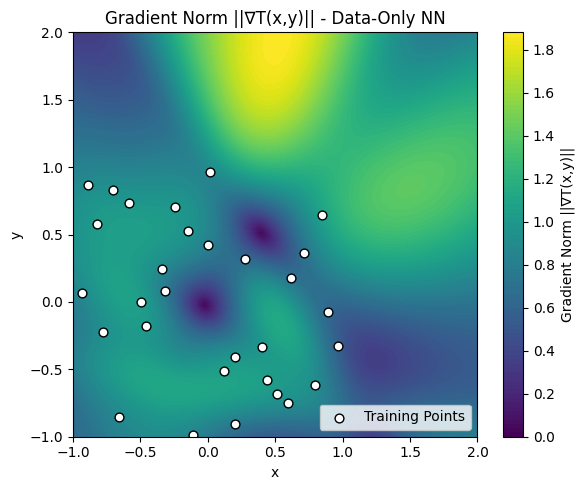

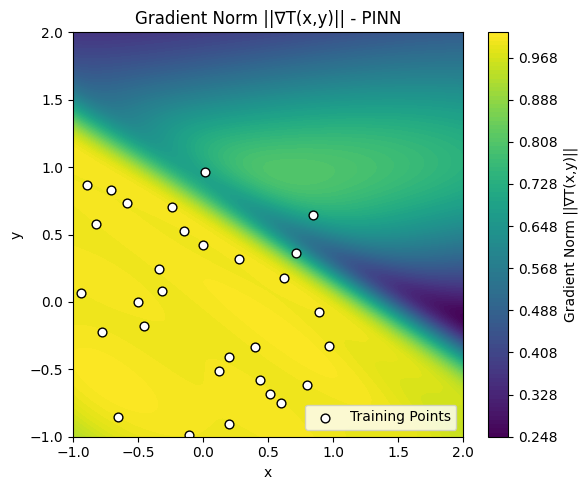

In [16]:
# Create mesh grid for evaluation
grid_x, grid_y = np.meshgrid(np.linspace(-1, 2, 100), np.linspace(-1, 2, 100))
grid_coords = np.stack([grid_x.ravel(), grid_y.ravel()], axis=1)
X_grid = torch.tensor(grid_coords, dtype=torch.float32).to(device)

# Function to compute gradient norm via automatic differentiation
def compute_gradient_norm(model, x):
    x = x.clone().detach().requires_grad_(True)
    t_pred = model(x)
    grads = grad(t_pred, x, grad_outputs=torch.ones_like(t_pred), create_graph=False)[0]
    grad_norm = torch.norm(grads, dim=1)
    return grad_norm

# Compute gradient norms for both models
grad_norm_data = compute_gradient_norm(model_data, X_grid).detach().cpu().numpy()
grad_norm_pinn = compute_gradient_norm(model_pinn, X_grid).detach().cpu().numpy()

# Print mean gradient norms
print(f"Mean gradient norm (Data-Only NN): {grad_norm_data.mean():.5f}")
print(f"Mean gradient norm (PINN): {grad_norm_pinn.mean():.5f}")

# Plotting function
def plot_heatmap(values, title):
    plt.figure(figsize=(6, 5))
    plt.contourf(grid_x, grid_y, values.reshape(grid_x.shape), levels=100, cmap='viridis')
    plt.colorbar(label='Gradient Norm ||∇T(x,y)||')
    plt.scatter(x_train, y_train, color='white', edgecolor='black', s=40, label='Training Points')
    plt.legend(loc='lower right')
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.tight_layout()
    plt.show()

# Plot gradient norms
plot_heatmap(grad_norm_data, "Gradient Norm ||∇T(x,y)|| - Data-Only NN")
plot_heatmap(grad_norm_pinn, "Gradient Norm ||∇T(x,y)|| - PINN")

##  2. This assignment introduces Neural Ordinary Differential Equations (NeuralODEs) as a continuous alternative to standard neural network layers.You will compare a standard 1-hidden-layer neural network with a Neural ODE model for a simple classification task.

## PART A

## IMPORTING LIBRARY AND DATASET SETUP (MOONS)

In [25]:
# === Step 1: Imports ===
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap



## a) Create and train a simple fully connected neural network with one  hidden layer(e.g.,16–32neurons and ReLU activation). 

In [26]:
# === Step 3: Simple Fully Connected Neural Network ===
class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 32)  # One hidden layer, 32 neurons
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 2)  # Binary classification (2 classes)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        return self.fc2(x)


## b) Define dataset (moons)

In [27]:
# === Step 2: Generate 2D Toy Dataset ===
X, y = make_moons(n_samples=1000, noise=0.2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.long)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.long)


## c) Reporting training and testing accuracy

Epoch 0, Loss: 0.6094
Epoch 100, Loss: 0.1194
Epoch 200, Loss: 0.0743
Epoch 300, Loss: 0.0692
Epoch 400, Loss: 0.0676
Epoch 500, Loss: 0.0666
Epoch 600, Loss: 0.0647
Epoch 700, Loss: 0.0634
Epoch 800, Loss: 0.0621
Epoch 900, Loss: 0.0610
Epoch 1000, Loss: 0.0603
Epoch 1100, Loss: 0.0595
Epoch 1200, Loss: 0.0586
Epoch 1300, Loss: 0.0578
Epoch 1400, Loss: 0.0569
Epoch 1500, Loss: 0.0557
Epoch 1600, Loss: 0.0546
Epoch 1700, Loss: 0.0538
Epoch 1800, Loss: 0.0531
Epoch 1900, Loss: 0.0522
Train Accuracy: 0.9757
Test Accuracy: 0.9533


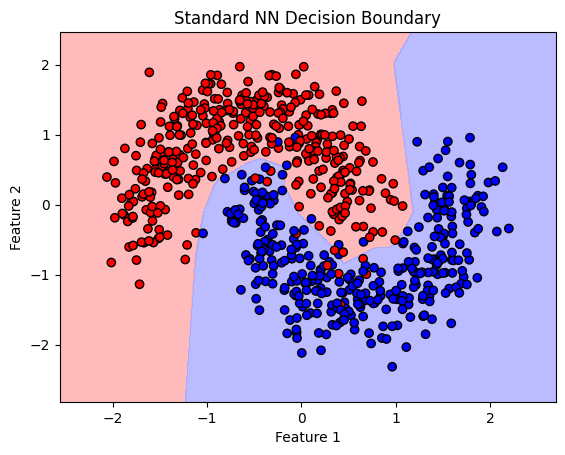

In [28]:
# === Step 4: Training Function ===
def train_model(model, X_train, y_train, X_test, y_test, epochs=2000):
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    model.train()

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

    model.eval()
    with torch.no_grad():
        train_pred = model(X_train).argmax(dim=1)
        test_pred = model(X_test).argmax(dim=1)
        train_acc = accuracy_score(y_train.numpy(), train_pred.numpy())
        test_acc = accuracy_score(y_test.numpy(), test_pred.numpy())

    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    return model
# Train model
simple_model = SimpleNN()
simple_model = train_model(simple_model, X_train_torch, y_train_torch, X_test_torch, y_test_torch)

# Plot decision boundary
def plot_decision_boundary(model, X, y, title="Decision Boundary"):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]
    with torch.no_grad():
        Z = model(torch.tensor(grid, dtype=torch.float32)).argmax(dim=1).numpy()
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']), alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(['#FF0000', '#0000FF']), edgecolor='k')
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

# Visualize
plot_decision_boundary(simple_model, X_train, y_train, title="Standard NN Decision Boundary")


### PART B

##  (a) Replace the hidden layer with a Neural ODE block. Define an ODE of the form:dh/dt =f(h,t) where f(h,t) is a small neural network (e.g., 2 layers, 16 neurons per layer).

In [42]:
# Define the ODE Function f(h, t)
class ODEFunc(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 2)  # Output is dh/dt (same dimension as input h)
        )


    def forward(self, t, h):
        return self.net(h)


 ## (b) Use the torchdiffeq package (https://github.com/rtqichen/torchdiffeq) and the odeint function with a simple solver such as rk4 or dopri5.

In [33]:
# Import the torchdiffeq library
!pip install torchdiffeq
from torchdiffeq import odeint


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.1 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-

## (c) Evolve the hidden state over a time interval t ∈ [0,1] and use the output for classification.

In [51]:
# Step 3: Define the full Neural ODE model
class NeuralODEModel(nn.Module):
    def __init__(self, odefunc):
        super().__init__()
        self.odefunc = odefunc
        self.classifier = nn.Linear(2, 2)  # After integration, classify

    def forward(self, x):
        t = torch.tensor([0.0, 1.0]).to(x.device)  # time from 0 to 1
        out = odeint(self.odefunc, x, t, method= 'rk4')  # Shape: [2, batch_size, dim]
        final_state = out[-1]  # Take output at t=1
        return self.classifier(final_state)


## (d) Train the model and compare accuracy and behavior with the baseline.

Epoch 0, Loss: 0.8361
Epoch 100, Loss: 0.0814
Epoch 200, Loss: 0.0570
Epoch 300, Loss: 0.0497
Epoch 400, Loss: 0.0560
Epoch 500, Loss: 0.0411
Epoch 600, Loss: 0.0467
Epoch 700, Loss: 0.0454
Epoch 800, Loss: 0.0374
Epoch 900, Loss: 0.0391
Epoch 1000, Loss: 0.0430
Epoch 1100, Loss: 0.0424
Epoch 1200, Loss: 0.0348
Epoch 1300, Loss: 0.0369
Epoch 1400, Loss: 0.0348
Epoch 1500, Loss: 0.0423
Epoch 1600, Loss: 0.0373
Epoch 1700, Loss: 0.0325
Epoch 1800, Loss: 0.0340
Epoch 1900, Loss: 0.0318

✅ Final Train Accuracy: 0.9771
✅ Final Test Accuracy: 0.9467


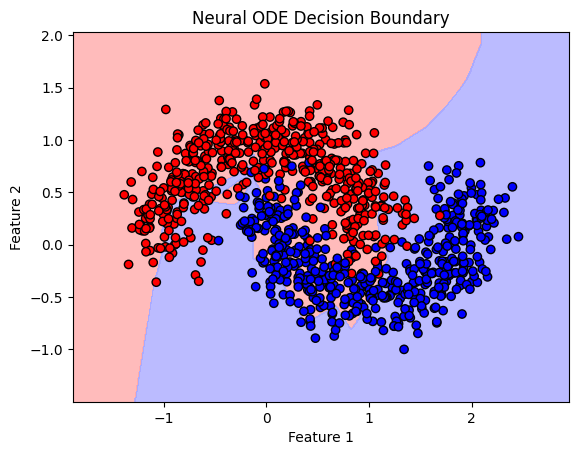

In [54]:
# ==== 4. Train the Model ====
def train_model(model, X_train, y_train, X_test, y_test, epochs=2000):
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

    # Final evaluation
    model.eval()
    with torch.no_grad():
        train_pred = model(X_train).argmax(dim=1)
        test_pred = model(X_test).argmax(dim=1)
        train_acc = accuracy_score(y_train.cpu(), train_pred.cpu())
        test_acc = accuracy_score(y_test.cpu(), test_pred.cpu())

    print(f"\n✅ Final Train Accuracy: {train_acc:.4f}")
    print(f"✅ Final Test Accuracy: {test_acc:.4f}")
    return model

# ==== 5. Run Training ====
ode_func = ODEFunc()
neural_ode_model = NeuralODEModel(ode_func).to(device)
neural_ode_model = train_model(neural_ode_model, X_train_torch, y_train_torch, X_test_torch, y_test_torch)

# ==== 6. Plot Decision Boundary ====
def plot_decision_boundary(model, X, y, title="Decision Boundary"):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_torch = torch.tensor(grid, dtype=torch.float32).to(device)

    with torch.no_grad():
        Z = model(grid_torch).argmax(dim=1).cpu().numpy()
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']), alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(['#FF0000', '#0000FF']), edgecolor='k')
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

plot_decision_boundary(neural_ode_model, X, y, title="Neural ODE Decision Boundary")

## PART C

##  (a) Compare performance (accuracy and loss) of both models.

In [55]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score

# Assume these are your trained models
# simple_model
# neural_ode_model

# Criterion
criterion = nn.CrossEntropyLoss()

def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.eval()
    with torch.no_grad():
        # Train eval
        train_outputs = model(X_train)
        train_loss = criterion(train_outputs, y_train).item()
        train_pred = train_outputs.argmax(dim=1)
        train_acc = accuracy_score(y_train.numpy(), train_pred.numpy())

        # Test eval
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test).item()
        test_pred = test_outputs.argmax(dim=1)
        test_acc = accuracy_score(y_test.numpy(), test_pred.numpy())

    return train_loss, train_acc, test_loss, test_acc

# Evaluate Standard NN
train_loss_s, train_acc_s, test_loss_s, test_acc_s = evaluate_model(simple_model, X_train_torch, y_train_torch, X_test_torch, y_test_torch)

# Evaluate Neural ODE
train_loss_ode, train_acc_ode, test_loss_ode, test_acc_ode = evaluate_model(neural_ode_model, X_train_torch, y_train_torch, X_test_torch, y_test_torch)

print("Standard NN Performance:")
print(f"Train Loss: {train_loss_s:.4f}, Train Accuracy: {train_acc_s:.4f}")
print(f"Test Loss:  {test_loss_s:.4f}, Test Accuracy:  {test_acc_s:.4f}")

print("\nNeural ODE Performance:")
print(f"Train Loss: {train_loss_ode:.4f}, Train Accuracy: {train_acc_ode:.4f}")
print(f"Test Loss:  {test_loss_ode:.4f}, Test Accuracy:  {test_acc_ode:.4f}")


Standard NN Performance:
Train Loss: 0.0508, Train Accuracy: 0.9757
Test Loss:  0.1660, Test Accuracy:  0.9533

Neural ODE Performance:
Train Loss: 0.0459, Train Accuracy: 0.9771
Test Loss:  0.3704, Test Accuracy:  0.9467
